# Detecção e tratamento de outliers

Os outliers podem ser observados tanto olhando para uma variável específica (univariado) ou pra um conjunto (multivariado).

Exemplos:

**Univariado:** Uma pessoa com idade de 120 anos ou  uma temperatura de 50 graus celsius na Antártida.

**Multivariado:** Uma pessoa com 2 metros de comprimento e somente 50kg de peso.

Refs:

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0

Outras fontes:

https://www.kdnuggets.com/2017/01/3-methods-deal-outliers.html

http://www.hermanaguinis.com/ORMoutliers.pdf

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import pandas as pd
import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataframe
df = pd.read_csv('boston.csv')

## Detecção em dados univariados

In [3]:
# Observar as escalas das variáveis
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


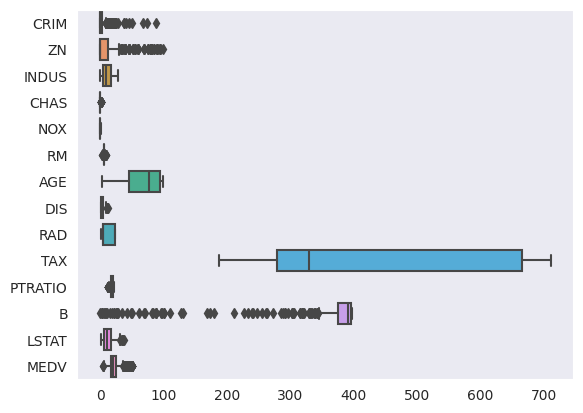

In [4]:
# Boxplot para se ter uma ideia da concentração dos dados
# INDUS, AGE, RAD e TAX não sofrem com outliers
sns.boxplot(data=df, orient='h');

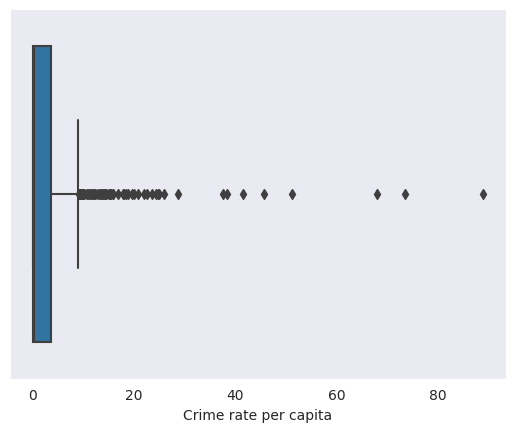

In [5]:
# A taxa de crimes fica abaixo de 5% para a maioria dos casos
ax = sns.boxplot(x=df["CRIM"])
ax.set_xlabel('Crime rate per capita');

**Box plots are great to summarize and visualize the distribution of variables easily and quickly. However, they do not identify the actual indexes of the outlying observations.**

### Tukey’s box plot method

Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer fence, whereas a probable outlier is located outside the outer fence.

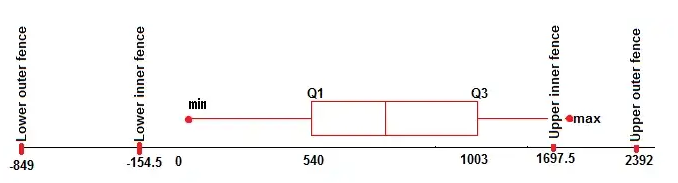

The distribution’s inner fence is defined as 1.5 x IQR below Q1, and 1.5 x IQR above Q3. The outer fence is defined as 3 x IQR below Q1, and 3 x IQR above Q3.

The great advantage of Tukey’s box plot method is that the statistics (e.g. IQR, inner and outer fence) are robust to outliers, meaning to find one outlier is independent of all other outliers and this method does not require a normal distribution of the data.

In [6]:
def tukeys_method(df, variable):
    q1 = df[variable].quantile(.25)
    q3 = df[variable].quantile(.75)
    iqr = q3 - q1
    inner_fence_val = iqr * 1.5
    outer_fence_val = iqr * 3
    
    # inner (possible outliers)
    inner_fence_le = q1 - inner_fence_val
    inner_fence_gr = q3 + inner_fence_val
    
    # outer (probable outliers)
    outer_fence_le = q1 - outer_fence_val
    outer_fence_gr = q3 + outer_fence_val
    
    df_temp = df[[variable]]
    df_temp = df_temp.assign(
                possible_outlier = df_temp.apply(lambda x: 1 if  x[variable] <= inner_fence_le or x[variable] >= inner_fence_gr else 0, axis=1),
                probable_outlier = df_temp.apply(lambda x: 1 if  x[variable] <= outer_fence_le or x[variable] >= outer_fence_gr else 0, axis=1))
    df_temp.fillna(0)
    
    possible = df_temp[df_temp.possible_outlier == 1]['possible_outlier'].count()
    probable = df_temp[df_temp.probable_outlier == 1]['probable_outlier'].count()
    print(f'Var: {variable} -> Inner qtd: {possible} -- Outer qtd: {probable}')
    
    return df_temp

dd = tukeys_method(df, 'CRIM')

Var: CRIM -> Inner qtd: 66 -- Outer qtd: 30


**Tukey method to highly skewed**

If a distribution is highly skewed, the Tukey method can be extended to the log-IQ method.

In [7]:
# To avoid log(0) -> variable + 1

def calc_log(df, variable):
    df_temp = df[[variable]]
    if df_temp[df_temp[variable] == 0][variable].count() != 0:
        df_temp[variable] = df_temp.apply(lambda x: x[variable] + 1, axis=1)
    
    df_temp[f'{variable}_log'] = np.log(df_temp[variable])
    return df_temp

dd = calc_log(df, 'CRIM')
dd = tukeys_method(dd, 'CRIM_log')

Var: CRIM_log -> Inner qtd: 0 -- Outer qtd: 0


### Internally studentized residuals AKA z-score method

For each observation (Xn), it is measured how many standard deviations the data point is away from its mean (X̄).

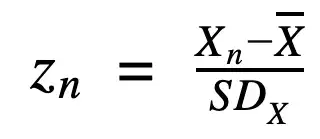

Following a common rule of thumb, if z > C, where C is usually set to 3, the observation is marked as an outlier. This rule stems from the fact that if a variable is normally distributed, 99.7% of all data points are located 3 standard deviations around the mean.

In [8]:
def z_score_method(df, variable):
    threshold = 3
    df_temp = df[[variable]]
    df_temp['z_score'] = np.abs(stats.zscore(df_temp[variable]))
    df_temp['z_outlier'] = df_temp.apply(lambda x: 1 if x.z_score > threshold else 0, axis=1)
    df_temp.fillna(0)

    z_outliers = df_temp[df_temp.z_outlier == 1]['z_outlier'].count()
    print(f'Var: {variable} -> Z-score outlier qtd: {z_outliers}')
    return df_temp
          
dd = z_score_method(df, 'CRIM')

Var: CRIM -> Z-score outlier qtd: 8


This method is highly limited as the distributions mean and standard deviation are sensitive to outliers. This means that finding one outlier is dependent on other outliers as every observation directly affects the mean.

Moreover, the z-score method assumes the variable of interest to be normally distributed. A more robust method that can be used instead is the externally studentized residuals. Here, the influence of the examined data point is removed from the calculation of the mean and standard deviation, like so:

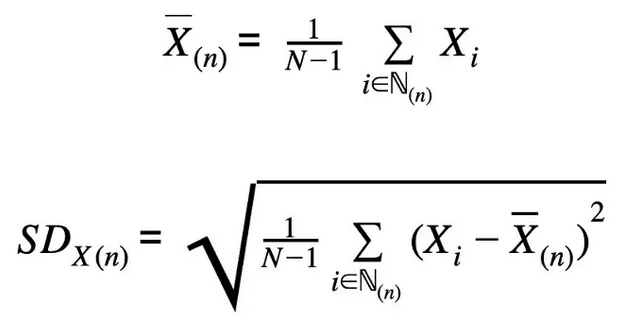

Nevertheless, the externally studentized residuals have limitations as the mean and standard deviations are still sensitive to other outliers and still expect the variable of interest X to be normally distributed.

### Median Absolute Deviation method

The median absolute deviation method (MAD) replaces the mean and standard deviation with more robust statistics, like the median and median absolute deviation. The median absolute deviation is defined as:

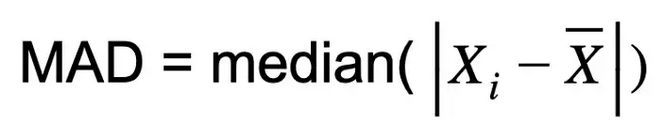

Sobre MAD: https://en.wikipedia.org/wiki/Median_absolute_deviation

The test statistic is calculated like the z-score using robust statistics. Also, to identify outlying observations, the same cut-off point of 3 is used. If the test statistic lies above 3, it is marked as an outlier. Compared to the internally (z-score) and externally studentized residuals, this method is more robust to outliers and does assume X to be parametrically distributed.

In [9]:
def mad_method(df, variable):
    threshold = 3
    med = np.median(df[variable])
    mad = np.abs(stats.median_abs_deviation(df[variable]))
    df_temp = df[[variable]]
    df_temp['mad_score'] = df_temp.apply(lambda x: (x[variable] - med) / mad, axis=1)
    df_temp['mad_outlier'] = df_temp.apply(lambda x: 1 if x.mad_score > threshold else 0, axis=1)
    df_temp.fillna(0)
    mad_outliers = df_temp[df_temp.mad_outlier == 1]['mad_outlier'].count()
    print(f'Var: {variable} -> MAD outlier qtd: {mad_outliers}')
    return df_temp
          
dd = mad_method(df, 'CRIM')

Var: CRIM -> MAD outlier qtd: 177


There are different ways to detect univariate outliers, each one coming with advantages and disadvantages. The z-score needs to be applied critically due to its sensitivity to mean and standard deviation and its assumption of a normally distributed variable. The MAD method is often used instead and serves as a more robust alternative. Tukey’s box plot method offers robust results and can be easily extended when the data is highly skewed.

## Detecção em dados multivariados

--> When dealing with multivariate outliers, **distance metrics** can be helpful for detection.

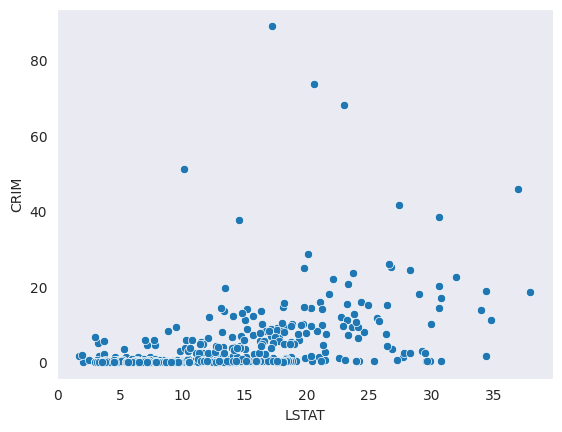

In [10]:
# Usando scatter pra analisar essas 2 variáveis
sns.scatterplot(x="LSTAT", y="CRIM", data=df);

### Mahalanobis Distance

Is a measure that determines the distance between a data point x and a distribution D. It is a multivariate generalization of the internally studentized residuals (z-score) introduced in my last article. This means the MD defines how many standard deviations x is away from the mean of D.

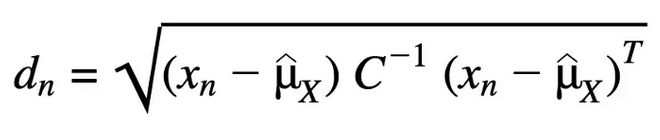

Here, x represents an observation vector and µ the arithmetic mean vector of independent variables (columns) in the sample. C(-1) is the inverse covariance matrix of the independent variables in the sample.

Like the z-score, the MD of each observation is compared to a cut-off point. Assuming a multivariate normal distribution of the data with K variables, the Mahalanobis distance follows a chi-squared distribution with K degrees of freedom. Using a reasonable significance level (e.g., 2.5%, 1%, 0.01%), the cut-off point is defined as:

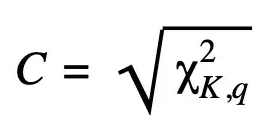

Sobre MD: https://www.machinelearningplus.com/statistics/mahalanobis-distance/

In [38]:
def mahalanobis_method(df):
    df_temp = df.copy()
    
    # Calcula MD
    x_minus_mu = df_temp - np.mean(df_temp)
    inv_cov = np.linalg.inv(np.cov(df_temp.values.T))
    
    # (x-mu)C**-1
    x_minus_mu_dot_inv_cov = np.dot(x_minus_mu, inv_cov)
    
    # (x-mu)C**-1(x-mu)T
    mahal = np.dot(x_minus_mu_dot_inv_cov, x_minus_mu.T)
    
    # sqrt((x-mu)C**-1(x-mu)T)
    df_temp['md'] = np.sqrt(mahal.diagonal())
    
    # Calcula ponto de corte
    C = np.sqrt(stats.chi2.ppf((1 - 0.001), df=df_temp.shape[1]))
    
    # identifica cortes
    df_temp['md_outlier'] = df_temp.apply(lambda x: 1 if x.md > C else 0, axis=1)
    df_temp.fillna(0)
    md_outliers = df_temp[df_temp.md_outlier == 1]['md_outlier'].count()
    
    variables = df_temp.columns[0:-2]
    print(f'Var: {variables} -> MD outlier qtd: {md_outliers}')
    return df_temp

In [39]:
dd = mahalanobis_method(df[['LSTAT', 'CRIM']])

Var: Index(['LSTAT', 'CRIM'], dtype='object') -> MD outlier qtd: 8


A drawback of the MD is that it uses the arithmetic mean and covariance matrix and, with that, is **highly sensitive to outliers** in the data.

### Robust Mahalanobis Distance

The Minimum Covariance Determinant method (MCD) provides robust estimates for µ and C by only using a subset of the sample. It only uses the observations where the determinant of the covariance matrix is as small as possible.

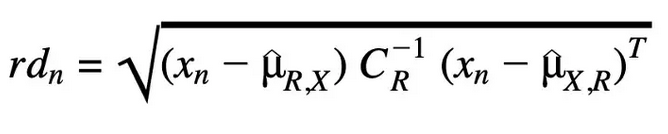

Sobre MCD: https://arxiv.org/pdf/1709.07045.pdf

In [84]:
from sklearn.covariance import MinCovDet

def robust_mahalanobis_method(df):
    df_temp = df.copy()
    seed = 13
    
    # Calcula o MCD (minimum covariance determinant)
    rng = np.random.RandomState(seed)
    real_cov = np.cov(df_temp.values.T)
    X = rng.multivariate_normal(mean=np.mean(df_temp, axis=0), cov=real_cov, size=df_temp.shape[0])
    cov = MinCovDet(random_state=seed).fit(X)
    mcd = cov.covariance_
    robust_mean = cov.location_
    inv_cov = np.linalg.inv(mcd)
    
    # Calcula Robust MD
    x_minus_mu = df_temp - robust_mean
    x_minus_mu_dot_inv_cov = np.dot(x_minus_mu, inv_cov)
    mahal = np.dot(x_minus_mu_dot_inv_cov, x_minus_mu.T)
    df_temp['md'] = np.sqrt(mahal.diagonal())
    
    # Calcula ponto de corte
    C = np.sqrt(stats.chi2.ppf((1 - 0.001), df=df_temp.shape[1]))
    
    # identifica cortes
    df_temp['md_outlier'] = df_temp.apply(lambda x: 1 if x.md > C else 0, axis=1)
    df_temp.fillna(0)
    md_outliers = df_temp[df_temp.md_outlier == 1]['md_outlier'].count()
    
    variables = df_temp.columns[0:-2]
    print(f'Var: {variables} -> MD outlier qtd: {md_outliers}')
    return df_temp

In [85]:
dd = robust_mahalanobis_method(df[['LSTAT', 'CRIM']])

Var: Index(['LSTAT', 'CRIM'], dtype='object') -> MD outlier qtd: 8


## Tratamento de Outliers

--> Quando os outliers provêm de erro o ideal é que os valores sejam removidos. Acontece que podem ser **non-erro** e abaixo algumas dicas de como tratá-los:

**Non-error outliers**, also called **interesting** or **random outliers**, are part of the population of interest and may hold interesting information.

**Handling non-error outliers:**

**Keep**

When most of the detected outliers are non-error outliers and rightfully belong to the population of interest, this is a good strategy. Also, you often cannot easily identify whether or not an extreme value is a part of the population of interest or not.

When keeping outliers, be aware that they can distort the results of your actual task: e.g. lead to a rejection of the null hypothesis or an over-optimistic prediction. Therefore, it might be worth your while to report your findings, including outliers and excluding outliers to highlight the impact they can have.

Another option are robust methods for your actual prediction task or analysis. These methods reduce the influence of extreme values using more robust statistics (e.g., median) or other non-parametric settings (e.g., rank-tests, bootstrapping, or Support Vector Machines).

For univariate and multivariate outliers:

* Collect qualitative information by including and excluding outliers in your analysis to assess their actual impact
* Use robust methods to reduce the impact of outliers
* Keep outliers if they are likely to belong to the population of interest and beware of the risks they bring when making decisions
* And always and most importantly: Report all findings!

**Delete**

The most straightforward option is to delete any outlying observation. However, this strategy bears a high risk of losing information. Especially if you find many outlying data points, try to avoid this. Also, deleting interesting and influential outliers (points that belong to the population of interest) can falsely impact any output, e.g., prediction or test result, you aim to achieve.

For univariate and multivariate outliers:

* Remove outliers on a low scale and those that are not likely to be from another population
* If you choose deletion, always provide two reports of your analysis or outcomes: one with and one without outlying observations

**Recode**

Recoding outliers is a good option to treat outliers and keep as much information as possible simultaneously. This option should always be accompanied by sound reasoning and explanation. There are several different methods to recode an outlier, and in this article, I want to focus on two widely used methods:

* Winsorizing
* Imputation

### Winsorizing

With winsorizing, any value of a variable above or below a percentile k on each side of the variables’ distribution is replaced with the value of the k-th percentile itself. For example, if k=5, all observations above the 95th percentile are recoded to the value of the 95th percentile, and values below the 5th percent are recoded, respectively. Compared to trimming, winsorizing is a less extreme option by recoding outliers rather than cutting them altogether.

Winsorization also directly intervenes with the process of outlier detection. The data points above or below a certain threshold are treated, and no independent detection method is needed. However, it goes hand-in-hand with Tukey’s boxplot method as k is often recommended to be set at a sample’s outer fence (3 standard deviations around the mean). This is often at k=5 and, therefore, used as the default value.

In [93]:
def tukeys_method(df, variable):
    q1 = df[variable].quantile(.25)
    q3 = df[variable].quantile(.75)
    iqr = q3 - q1
    inner_fence_val = iqr * 1.5
    outer_fence_val = iqr * 3
    
    # inner (possible outliers)
    inner_fence_le = q1 - inner_fence_val
    inner_fence_gr = q3 + inner_fence_val
    
    # outer (probable outliers)
    outer_fence_le = q1 - outer_fence_val
    outer_fence_gr = q3 + outer_fence_val
    
    print(f'Inner fence variable {variable} : LE: {inner_fence_le} -- GR {inner_fence_gr}')
    print(f'Outer fence variable {variable} : LE: {outer_fence_le} -- GR {outer_fence_gr}')

def print_quantile(df, variable, val_quantile):
    print(f'{val_quantile*100}% quantile: {df[variable].quantile(val_quantile)}')

tukeys_method(df, 'CRIM')

print()
for i in np.arange(0.9, 1.0, 0.01):
    print_quantile(df, 'CRIM', i)

Inner fence variable CRIM : LE: -5.31051125 -- GR 9.06963875
Outer fence variable CRIM : LE: -10.7030675 -- GR 14.462195000000001

90.0% quantile: 10.753
91.0% quantile: 11.706820000000002
92.0% quantile: 12.965980000000007
93.0% quantile: 14.002645000000005
94.0% quantile: 14.43305
95.0% quantile: 15.78915
96.00000000000001% quantile: 18.415480000000027
97.00000000000001% quantile: 21.85086500000011
98.00000000000001% quantile: 25.021660000000008
99.00000000000001% quantile: 41.370330000000145


Seguindo a premissa da utilização de k=5 por conta dos 3 desvios e vendo que o outer fence da variável é próxima ao valor de quantile 95, o k=5 será utilizado para efetuação do winsorizing.

             CRIM  CRIM_win_95
count  506.000000   506.000000
mean     3.613524     2.799611
std      8.601545     4.678292
min      0.006320     0.006320
25%      0.082045     0.082045
50%      0.256510     0.256510
75%      3.677083     3.677083
max     88.976200    15.860300


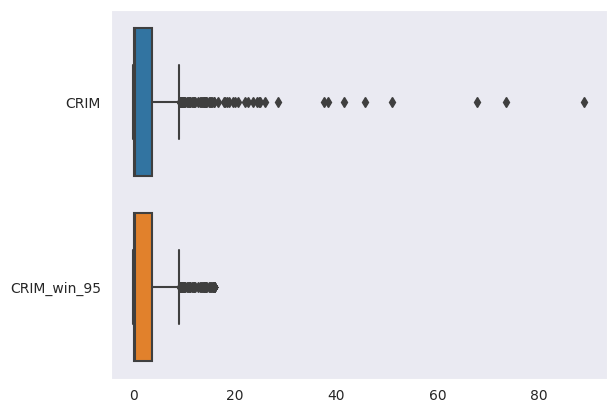

In [104]:
from scipy.stats.mstats import winsorize

df_win = df[['CRIM']].copy()
df_win['CRIM_win_95'] = winsorize(df_win['CRIM'], limits=(0, 0.05))

print(df_win.describe())

sns.boxplot(data=df_win, orient='h');

For univariate outliers:

* Winsorize to keep as much data as possible;
* To find the right winsorization level, know your data! A percentage point close to the outer fence is considered best practice;
* Zero limits can be meaningful if a variable can not have a value below zero;
* Report main statistics (e.g., mean, std) before and after winsorizing;

For multivariate outliers:

* For multivariate outliers, winsorizing is done on the ellipsoid (holding information from more than one variable)
* There doesn’t seem to be an existing python package that deals with winsorization on ellipsoids. Yet, there exists a function called mvTopCoding as part of an R package sdcMicro that winsorizes outliers on the ellipsoid defined by the (robust) Mahalanobis distance.

### Imputation

Imputation is a method that is often used when handling missing data. However, it is also applied when dealing with extreme values. When using imputation, outliers are removed (and with that become missing values) and are replaced with estimates based on the remaining data.

There are several imputation techniques. One that is often used, yet comes with a **strong bias**, is the simple **mean** substitution. Here, all outlier or missing values are substituted by the variables’ mean. A better alternative and more robust imputation method is the multiple imputation.

In multiple imputation, missing values or outliers are replaced by M plausible estimates retrieved from a prediction model. The outlier becomes the dependent variable of a prediction model (e.g., regression, random forest etc.), and is estimated based on the remaining information non-missing/non-outlier values in an observation.

Sobre imputation: https://stefvanbuuren.name/fimd/sec-howmany.html

In [132]:
def tukeys_method(df, variable):
    q1 = df[variable].quantile(.25)
    q3 = df[variable].quantile(.75)
    iqr = q3 - q1
    outer_fence_val = iqr * 3

    outer_fence_le = q1 - outer_fence_val
    outer_fence_gr = q3 + outer_fence_val
    
    df_temp = df[[variable]]
    df_temp['CRIM_prob_out'] = df_temp.apply(lambda x: None if  x[variable] <= outer_fence_le or x[variable] >= outer_fence_gr else x[variable], axis=1)
    
    return df_temp[['CRIM_prob_out']]

df_imp = tukeys_method(df, 'CRIM')

             CRIM  CRIM_prob_out
count  506.000000     506.000000
mean     3.613524       1.981452
std      8.601545       3.352871
min      0.006320       0.006320
25%      0.082045       0.082045
50%      0.256510       0.256510
75%      3.677083       1.981452
max     88.976200      14.438300


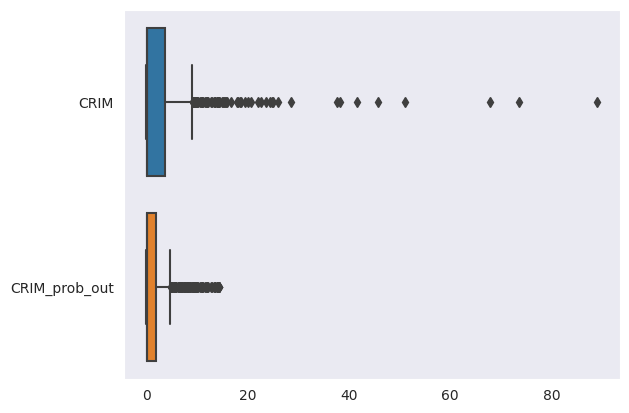

In [133]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

columns = df_imp.columns

imputer = IterativeImputer(estimator=BayesianRidge(),
                           imputation_order='ascending')

df_imp_tf = imputer.fit_transform(df_imp)

df_imp = pd.DataFrame(df_imp_tf, columns=columns)

# Concat datasets
df_imp = pd.concat([df[['CRIM']], df_imp], axis=1)

print(df_imp.describe())
sns.boxplot(data=df_imp, orient='h');

For univariate outliers:

* Next to treating missing data, often used technique for recoding outliers;
* Multiple imputation more robust, single (e.g., mean) imputation biased;
* For imputation, R offers more mature and flexible packages than python;

For multivariate outliers:

* Imputation does not really make sense for multivariate outliers as they are defined as outlying observations across multiple variables (for a multiple outlier all entries would turn into a missing value leaving little space for prediction);

Sklearn IterativeImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html